In [0]:
# In this exercise you will train a CNN on the FULL Cats-v-dogs dataset
# This will require you doing a lot of data preprocessing because
# the dataset isn't split into training and validation for you
# This code block has all the required inputs
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

In [24]:
# This code block downloads the full Cats-v-Dogs dataset and stores it as 
# cats-and-dogs.zip. It then unzips it to /tmp
# which will create a tmp/PetImages directory containing subdirectories
# called 'Cat' and 'Dog' (that's how the original researchers structured it)
# If the URL doesn't work, 
# .   visit https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765
# And right click on the 'Download Manually' link to get a new URL

!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip="/tmp/cats-and-dogs.zip"
zip_ref=zipfile.ZipFile(local_zip,"r")
zip_ref.extractall("/tmp")
zip_ref.close()


--2019-04-27 11:25:45--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.4.0.171, 2600:1407:16:2b3::e59, 2600:1407:16:29f::e59
Connecting to download.microsoft.com (download.microsoft.com)|23.4.0.171|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M   138MB/s    in 6.8s    

2019-04-27 11:25:52 (115 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



In [25]:
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

# Expected Output:
# 12501
# 12501

12501
12501


In [0]:
# Use os.mkdir to create your directories
# You will need a directory for cats-v-dogs, and subdirectories for training
# and testing. These in turn will need subdirectories for 'cats' and 'dogs'
try:
    os.mkdir('/tmp/cats-v-dogs')
    os.mkdir('/tmp/cats-v-dogs/training')
    os.mkdir('/tmp/cats-v-dogs/testing')
    os.mkdir('/tmp/cats-v-dogs/training/cats')
    os.mkdir('/tmp/cats-v-dogs/training/dogs')
    os.mkdir('/tmp/cats-v-dogs/testing/cats')
    os.mkdir('/tmp/cats-v-dogs/testing/dogs')
except OSError:
    pass

In [29]:
# Write a python function called split_data which takes
# a SOURCE directory containing the files
# a TRAINING directory that a portion of the files will be copied to
# a TESTING directory that a portion of the files will be copie to
# a SPLIT SIZE to determine the portion
# The files should also be randomized, so that the training set is a random
# X% of the files, and the test set is the remaining files
# SO, for example, if SOURCE is PetImages/Cat, and SPLIT SIZE is .9
# Then 90% of the images in PetImages/Cat will be copied to the TRAINING dir
# and 10% of the images will be copied to the TESTING dir
# Also -- All images should be checked, and if they have a zero file length,
# they will not be copied over
#
# os.listdir(DIRECTORY) gives you a listing of the contents of that directory
# os.path.getsize(PATH) gives you the size of the file
# copyfile(source, destination) copies a file from source to destination
# random.sample(list, len(list)) shuffles a list
def split_data(SOURCE,TRAINING,TESTING,SPLIT_SIZE):
  files=[]
  for filename in os.listdir(SOURCE):
    file=SOURCE+filename
    if os.path.getsize(file)>0:
      files.append(filename)
    else:
      print(filename + " is zero length, we are ignoring it!")
  
  training_length=int(len(files)*SPLIT_SIZE)
  testing_length=int(len(files)-training_length)
  shuffled_set=random.sample(files,len(files))
  training_set=shuffled_set[0:training_length]
  testing_set=shuffled_set[-testing_length:]
  
  for filename in training_set:
    this_file=SOURCE+filename
    destination=TRAINING+filename
    copyfile(this_file,destination)
  
  for filename in testing_set:
    this_file=SOURCE+filename
    destination=TESTING+filename
    copyfile(this_file,destination)
  


CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

# Expected output
# 666.jpg is zero length, so ignoring
# 11702.jpg is zero length, so ignoring

666.jpg is zero length, we are ignoring it!
11702.jpg is zero length, we are ignoring it!


In [30]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

# Expected output:
# 11250
# 11250
# 1250
# 1250

12381
12366
2381
2366


In [31]:
# DEFINE A KERAS MODEL TO CLASSIFY CATS V DOGS
# USE AT LEAST 3 CONVOLUTION LAYERS
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(16,(3,3),input_shape=(150,150,3),activation=tf.nn.relu),
  tf.keras.layers.MaxPooling2D(2,2), 
  tf.keras.layers.Conv2D(32,(3,3),activation=tf.nn.relu),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(64,(3,3),activation=tf.nn.relu),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512,activation=tf.nn.relu),
  tf.keras.layers.Dense(1,activation=tf.nn.sigmoid)  
])

model.compile(metrics=["accuracy"],optimizer=tf.train.RMSPropOptimizer(learning_rate=0.001),loss="binary_crossentropy")

Instructions for updating:
Colocations handled automatically by placer.


In [34]:
TRAINING_DIR = "/tmp/cats-v-dogs/training"
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,batch_size=100,target_size=(150,150),class_mode="binary")

VALIDATION_DIR = "/tmp/cats-v-dogs/testing"
validation_datagen = ImageDataGenerator(rescale=1.0/255.0)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,target_size=(150,150),batch_size=100,class_mode="binary")



# Expected Output:
# Found 22498 images belonging to 2 classes.
# Found 2500 images belonging to 2 classes.

Found 24745 images belonging to 2 classes.
Found 4747 images belonging to 2 classes.


In [36]:
history = model.fit_generator(train_generator,
                              epochs=15,
                              validation_data=validation_generator)

# The expectation here is that the model will train, and that accuracy will be > 95% on both training and validation
# i.e. acc:A1 and val_acc:A2 will be visible, and both A1 and A2 will be > .9

Epoch 1/15
 95/248 [==========>...................] - ETA: 50s - loss: 0.6907 - acc: 0.5305

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 80000 bytes but only got 0. Skipping tag 64640
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 3
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 307363840 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 307888128 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting t

 97/248 [==========>...................] - ETA: 49s - loss: 0.6907 - acc: 0.5314

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 18350080 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 6. 
  warnings.warn(str(msg))


176/248 [====================>.........] - ETA: 24s - loss: 0.6861 - acc: 0.5513

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but 

204/248 [=======================>......] - ETA: 14s - loss: 0.6812 - acc: 0.5620

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 404094976 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 404619264 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 425459712 bytes but only got 0. Skipping tag 4
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1385474 bytes but only got 6833. Skipping tag 513
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expe

205/248 [=======================>......] - ETA: 14s - loss: 0.6813 - acc: 0.5620

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 209715200 bytes but only got 0. Skipping tag 48
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 52428800 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6468665344 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1050744 bytes but only got 7027. Skipping tag 48
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expe

215/248 [=========================>....] - ETA: 10s - loss: 0.6798 - acc: 0.5655

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 262146 bytes but only got 0. Skipping tag 2
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 262151 bytes but only got 0. Skipping tag 56
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 0. 
  warnings.warn(str(msg))


13/48 [=======>......................] - ETA: 16s - loss: 0.5405 - acc: 0.7192

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6553600 bytes but only got 0. Skipping tag 49
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1050744 bytes but only got 4951. Skipping tag 51
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 293339136 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 293863424 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expect

248/248 [==============================] - 99s 398ms/step - loss: 0.6700 - acc: 0.5804 - val_loss: 0.5543 - val_acc: 0.7051
Epoch 2/15
248/248 [==============================] - 94s 380ms/step - loss: 0.5263 - acc: 0.7361 - val_loss: 0.4324 - val_acc: 0.7969
Epoch 3/15
248/248 [==============================] - 93s 377ms/step - loss: 0.4368 - acc: 0.7980 - val_loss: 0.3908 - val_acc: 0.8157
Epoch 4/15
248/248 [==============================] - 94s 380ms/step - loss: 0.3699 - acc: 0.8330 - val_loss: 0.2933 - val_acc: 0.8801
Epoch 5/15
248/248 [==============================] - 94s 377ms/step - loss: 0.2989 - acc: 0.8706 - val_loss: 0.2445 - val_acc: 0.9111
Epoch 6/15
248/248 [==============================] - 93s 374ms/step - loss: 0.2227 - acc: 0.9080 - val_loss: 0.3899 - val_acc: 0.8117
Epoch 7/15
248/248 [==============================] - 94s 378ms/step - loss: 0.1544 - acc: 0.9418 - val_loss: 0.1431 - val_acc: 0.9503
Epoch 8/15
248/248 [==============================] - 93s 374ms/st

<Figure size 432x288 with 0 Axes>

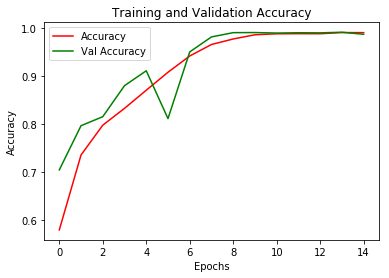

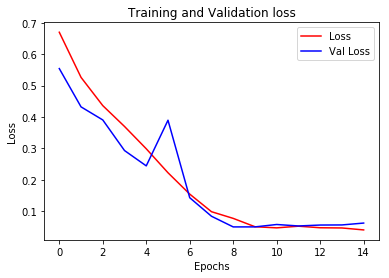

<Figure size 432x288 with 0 Axes>

In [43]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

acc=history.history["acc"]
val_acc=history.history["val_acc"]
loss=history.history["loss"]
val_loss=history.history["val_loss"]

total_epochs=len(acc)
epochs=range(len(acc))

plt.plot(epochs,acc,"r",label="Accuracy")
plt.plot(epochs,val_acc,"g",label="Val Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.figure()

plt.plot(epochs,loss,"r",label="Loss")
plt.plot(epochs,val_loss,"b",label="Val Loss")
plt.title("Training and Validation loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.figure()

In [47]:
# Here's a codeblock just for fun. You should be able to upload an image here 
# and have it classified without crashing

import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150,150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

Saving cat1.jpg to cat1.jpg
Saving cat2.jpg to cat2.jpg
Saving cat3.jpg to cat3.jpg
Saving cat4.jpg to cat4.jpg
Saving cat5.jpg to cat5.jpg
Saving dog2.jpg to dog2.jpg
Saving dog3.jpg to dog3.jpg
Saving dog4.jpg to dog4.jpg
Saving dog5.jpg to dog5.jpg
Saving dog6.jpg to dog6.jpg
Saving dog7.jpg to dog7.jpg
Saving dogs1.jpg to dogs1.jpg
Saving tiger1.jpg to tiger1.jpg
[0.]
cat1.jpg is a cat
[1.]
cat2.jpg is a dog
[0.]
cat3.jpg is a cat
[0.]
cat4.jpg is a cat
[0.]
cat5.jpg is a cat
[0.]
dog2.jpg is a cat
[1.]
dog3.jpg is a dog
[1.]
dog4.jpg is a dog
[1.]
dog5.jpg is a dog
[0.]
dog6.jpg is a cat
[1.]
dog7.jpg is a dog
[0.]
dogs1.jpg is a cat
[1.]
tiger1.jpg is a dog
